### Introduction

This tutorial shows how to use active learning to rapidly process a large dataset using a more computationally expensive method like docking, FEP, or 3D similarity calculations.  The code here is a scaled-down version of the code in our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204).  The code is fully functional.  I just removed a few of the options and benchmarks from our original work.  

### Installation

Install the necessary Python libraries.

In [ ]:
!pip install pandas numpy seaborn useful_rdkit_utils tqdm scikit-learn 'modAL-python>=0.4.1'

In [4]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from modAL.acquisition import optimizer_PI
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm
from modAL.utils.selection import multi_argmax
from rdkit.Chem import rdFingerprintGenerator

Grab the necessary data

In [5]:
import os, sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  import urllib.request

  os.makedirs("./data", exist_ok=True)
  url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/active_learning/data/tyk2_fep.csv"
  filename = "data/tyk2_fep.csv"
  urllib.request.urlretrieve(url,filename)

### Defining an Oracle

As with the classification example, we'll define an oracle that looks up values from a dataframe.  In practice, the oracle would perform some more expensive calculation like docking, FEP, or shape overlap. 

In [6]:
class Oracle:
    def __init__(self, df, col_name, invert=True):
        self.df = df
        self.col_name = col_name
        if invert:
            self.df[col_name] = self.df[col_name]

    def sample(self, num):
        sample_df = self.df.sample(num)
        return sample_df.fp.values, sample_df[self.col_name].values, sample_df.index

    def get_values(self, idx_list):
        return df[self.col_name].values[idx_list]

### Defining the Kernel Function for the Machine Learning Model

When we do active learning, we have to define a machine learning models that acts as a surrogate for the more expensive calculations.  In this case, we're going to use Gaussian Process Regression (GPR) to build our regression models.  To use GPR, we need to define a kernel function. Here we calculate a kernel based on the Tanimoto similarities of the molecules.

In [7]:
def calculate_similarity(a, b):
    # Tanimoto similarity a vs. b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)
    return np.true_divide(ab, aa + bb.T - ab)


class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):

    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X
        return calculate_similarity(X, Y)

### Reading the Data

Enable progress bars for the Pandas apply function.

In [8]:
tqdm.pandas()

Read the input data.  This data comes from ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204)

In [9]:
df = pd.read_csv("data/tyk2_fep.csv")

Take a quick look at the data.

In [10]:
df

,ligand_id,SMILES,dG_bind,dG_bind_err
0,0,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,-2.995,0.455
1,1,O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1ccccc1Cl,8.731,0.462
2,2,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1ccccc1Cl,3.316,0.448
3,3,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cc(Cl)cc1Cl,-0.070,0.462
4,4,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1cc(Cl)ccc1Cl,3.431,0.449
...,...,...,...,...
9992,9994,COc1cc(Cl)c(C(=O)Nc2cc(Nc3cccc(C(N)=O)n3)ncc2F...,3.288,0.512
9993,9995,COc1ccnc(Nc2cc(NC(=O)c3cccc(Cl)c3N)c(F)cn2)c1,15.143,0.478
9994,9996,O=C(COCc1ccccc1)Nc1cc(NC(=O)c2cccc(Cl)c2)c(F)cn1,5.480,0.500
9995,9997,COc1c(F)cccc1C(=O)Nc1ccnc(NC(=O)NC(C)C)c1,10.696,0.467


The data in the table is in kcal/mol, we'll convert to a pKd and call the new column "Activity".

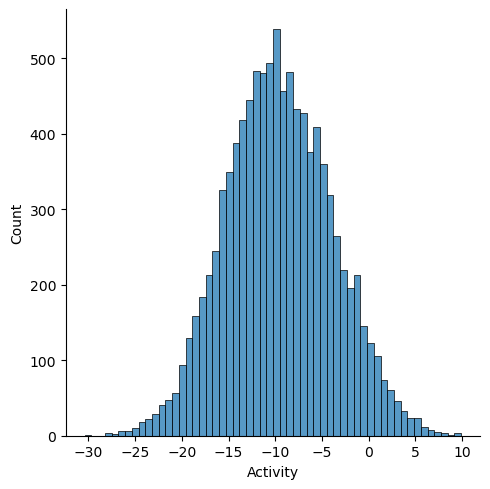

In [11]:
df['Activity'] = -np.log10(np.exp(df.dG_bind/0.5961)/1e-6)
sns.displot(df.Activity);

### Setup for Machine Learning 

Add an RDKit molecule column to the dataframe.

In [12]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/9997 [00:00<?, ?it/s]

Add a fingerprint column to the dataframe.

In [13]:
fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
df['fp'] = df.mol.progress_apply(fp_gen.GetFingerprintAsNumPy)

  0%|          | 0/9997 [00:00<?, ?it/s]

Create a pool for fingerprints for the active learning algorithm to draw from.

In [14]:
%%time
X_pool = np.stack(df.fp.values)

CPU times: user 11.2 ms, sys: 8.27 ms, total: 19.5 ms
Wall time: 21.1 ms


### Define Helper Functions for Active Learning

For the greedy search, we want to select the best scoring molecules, but we want to avoid selecting the same molecules multiple times. This function accepts a list of predictions and does the following.
- Sort by score
- Remove the molecules that were previously selected
- Return the top **n_to_choose**

In [15]:
def find_best_idx(predicted, used, num_to_choose):
    tmp_list = list(enumerate(predicted))
    tmp_list.sort(key=itemgetter(1), reverse=True)
    tmp_list = [x for x in tmp_list if x[0] not in used]
    tmp_list = [x[0] for x in tmp_list]
    return tmp_list[:num_to_choose]

Here are a couple of acquistion functions.  The first **greedy** simply selects the **n** top scoring molecules to be evaluated by the oracle.  The second **my_max_PI** maximizes the Probability of Improvement (PI) and uses uncertainty and the scores to balance exploration and exploitation.  The git repo associated with our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204) has examples of several other acquistion functions.  TLDR from our work, the acquistion function doesn't make a huge difference. 

In [16]:
def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    res = optimizer.predict(X)
    best_idx = find_best_idx(res, used, n_instances)
    return best_idx, X[best_idx]

def my_max_PI(optimizer: BaseLearner, X: modALinput, tradeoff: float = 0,
           n_instances: int = 1, used = [], cycle = -1) -> np.ndarray:
    pi = optimizer_PI(optimizer, X, tradeoff=tradeoff)
    best_idx = find_best_idx(pi, used, n_instances)
    return best_idx, X[best_idx]

### Create an Oracle

Create an oracle that will return values. This example oracle just looks up a value in a table.  In practice, you'd put code here to do a more expensive calculation.  The notebook **active_shape_search.ipynb** has a complete implementation of an oracle. 

In [17]:
value_column = "Activity"
oracle = Oracle(df, value_column)

### Run Active Learning

This is the main active learning loop.

In [18]:
# number of molecules to select at each active learning cycle
n_instances = 50
# number of active learning cycles to run
n_cycles = 5

# define the acquistion function, to change to greedy just change the line below
query_strategy = my_max_PI
# select an initial random cycle
X_initial, y_initial, sample_idx = oracle.sample(n_instances)
# instantiate the optimizer with an estimator, training data, and an acquistion function
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_initial), y_training=y_initial,
                              query_strategy=query_strategy)
# initialize a list of scores
val_list = [y_initial]
# keep track of which molecules we've sampled
used = list(sample_idx)
# the active learning loop
for i in tqdm(range(0, n_cycles)):
    # ask the optimizer for the next set of molecules
    query_idx, query_desc = optimizer.query(X_pool, n_instances=n_instances, used=used)
    # get values from the oracle, in practice, this is where we would do the more expensive calculations
    vals = oracle.get_values(query_idx)
    # add the returned values to val_list
    val_list.append(vals)
    # keep track of the molecules we've used
    used += query_idx
    # update the optimizer with the new values
    optimizer.teach(query_desc, vals)

  0%|          | 0/5 [00:00<?, ?it/s]

### Analyze Active Learning Results

Let's see how many of the top 100 molecules we found.

In [19]:
# sort the initial dataframe by score
ref_df = df.sort_values(value_column, ascending=False).head(100).copy()
# create a new dataframe with the selected molecules and sort by score
pick_df = df.iloc[used].sort_values(value_column, ascending=False).head(100).copy()
# merge the two dataframes to see how many molecules are in common
len(ref_df.merge(pick_df, on="ligand_id"))

49

Let's look at how the scores were distributed across the active learning cycles. First we need to put the data in a dataframe.

In [20]:
res_list = []
for idx, v in enumerate(val_list):
    res_list += [(idx, x) for x in v]
res_df = pd.DataFrame(res_list, columns=["cycle", value_column])
# add row numbers for the selected molecules
res_df['mol_idx'] = used
# add the SMILES for the selected molecules 
res_df['SMILES'] = df.SMILES.values[used]
# reorder the columns in res_df
res_df = res_df[['SMILES','cycle','mol_idx','Activity']]
res_df

,SMILES,cycle,mol_idx,Activity
0,N#CC1CC1C(=O)Nc1cc(NC(=O)c2cc(Cl)ccc2F)ccn1,0,849,-6.935471
1,Cc1cccc(C(=O)Nc2ccnc(NC(=O)NC3CCC3)c2)c1N,0,5735,-19.272902
2,Cc1ccc(N)cc1C(=O)Nc1cc(NC(=O)C2CCCCC2)ncc1F,0,3649,-6.864800
3,O=C(Nc1ccnc(NC(=O)C2CCCCC2)c1)c1c(F)cc(F)cc1F,0,223,-13.354811
4,CC(C)OC(=O)Nc1cc(NC(=O)c2ccccc2Cl)c(F)cn1,0,5779,0.451397
...,...,...,...,...
295,Cc1cc(Nc2cc(NC(=O)c3ccccc3Cl)c(F)cn2)nc(Cl)n1,5,7986,2.110327
296,CCOC(=O)c1ccc(Nc2cc(NC(=O)c3ccccc3Cl)c(F)cn2)nc1,5,8563,-1.686198
297,O=C(Nc1cc(NC(=O)c2cc(F)ccc2Cl)c(F)cn1)Oc1ccccc1,5,4981,2.599920
298,O=C(Nc1cc(Nc2ncco2)ncc1F)c1cc(F)ccc1Cl,5,8821,-1.310989


Plot the scores of the molecules selected in each active learning round.  Remember that the first active learning cycle was randomly selected. 

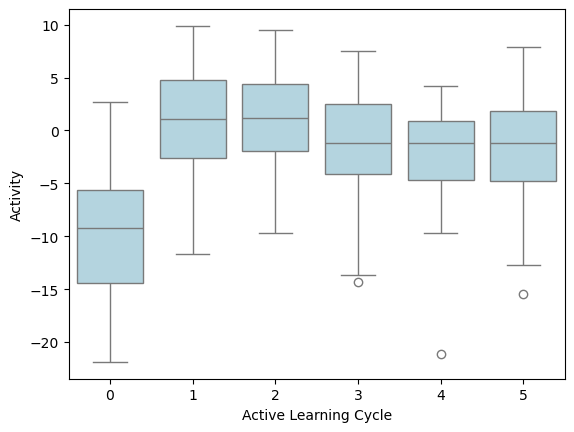

In [21]:
ax = sns.boxplot(x="cycle", y=value_column, data=res_df,color="lightblue")
ax.set_xlabel("Active Learning Cycle");

Now let's plot the distributions for the top 100 molecules from the input data vs the top 100 found using active learning.

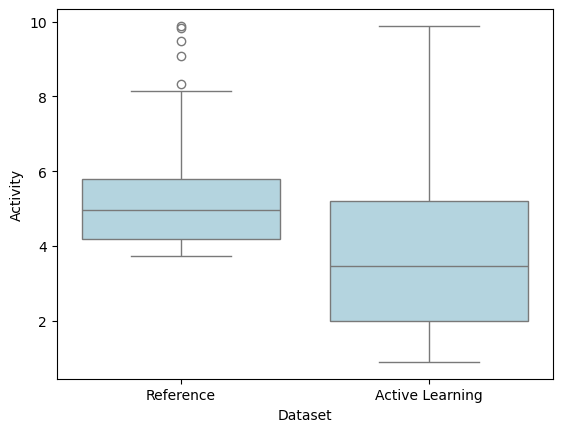

In [22]:
# Get a dataframe with the top 100 reference molecules
ref_top_100 = ref_df.sort_values("Activity",ascending=False).head(100).copy()
ref_top_100['Dataset'] = 'Reference'
# Get a dataframe with top 100 molecules predicted by active learning
pred_top_100 = res_df.sort_values("Activity",ascending=False).head(100).copy()
pred_top_100['Dataset'] = 'Active Learning'
# Make a boxplot comparing the scores of the top 100 molecules
ax = sns.boxplot(x="Dataset", y="Activity", data=pd.concat([ref_top_100,pred_top_100]),color="lightblue");
ax.set_ylabel("Activity");

We can also compare the scores of the molecules selected by active learning with scores from randomly selected molecules. 

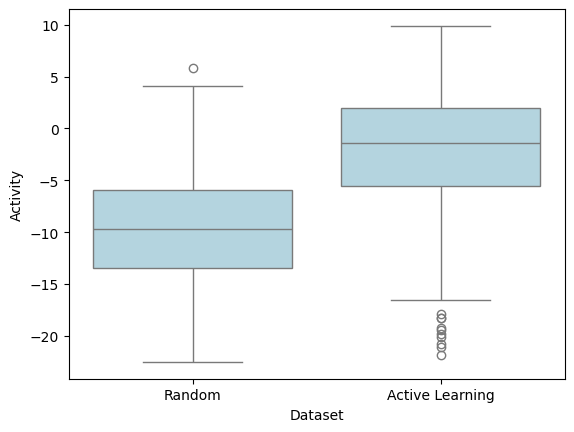

In [23]:
# Take a random sample from the input data that is the same size as the dataframe with the selected molecules
random_df = df.sample(len(res_df)).copy()
random_df['Dataset'] = 'Random'
# Label the active learning data
res_df['Dataset'] = 'Active Learning'
ax = sns.boxplot(x="Dataset", y="Activity", data=pd.concat([random_df,res_df]),color="lightblue");
ax.set_ylabel("Activity");